In [35]:
import urllib.request
import tarfile
import numpy as np
import random
import os
import torch
from PIL import Image
from torchvision import transforms
import zipfile
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `torch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# 5. If you are using CUDA, set also the seed for it and enable deterministic behavior
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU.
    # Below two lines ensure deterministic behavior, but may lead to slower training
    # due to the need to find algorithms that have deterministic behavior.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [18]:
# Check if CUDA is available
# Regardless of whether or not you are using GPU create the no gpu environment for now
is_cuda_available = torch.cuda.is_available()

# Print the status of CUDA availability
print("CUDA Available:", is_cuda_available)

# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if is_cuda_available else "cpu")

# Print the device being used
print("Using device:", device)

CUDA Available: True
Using device: cuda


In [19]:
data_dir = "data"
aug_data_dir = "sbd_dat_mat"
large_dataset = False # set to false if you want small dataset (0k images vs 10k images)

In [20]:
# Uncomment to download train_val dataset, comment afterwards

os.makedirs(data_dir, exist_ok=True)

voc_url = "http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar"
voc_name = "pascal_voc.tar"
voc_name = os.path.join(data_dir, voc_name)

urllib.request.urlretrieve(voc_url, voc_name)

with tarfile.open(voc_name) as tar:
    tar.extractall(path=data_dir)

In [21]:
# Augmentations dataset. This is a large dataset. Don't download unless you are planning on doing full training.
if large_dataset is True: 
    aug_data_dir = "sbd_dat_mat"
    os.makedirs(aug_data_dir, exist_ok=True)
    
    aug_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz"
    aug_name = os.path.join(aug_data_dir, 'sbd_aug.tar')
    
    # Downloading the file from the URL
    urllib.request.urlretrieve(aug_url, aug_name)
    
    with tarfile.open(aug_name) as tar:
        tar.extractall(path=aug_data_dir)

In [22]:
from data_loader import pascalVOCLoader
from augmentations import *

# motivation for cropping instead of resizing: https://github.com/VainF/DeepLabV3Plus-Pytorch
aug_list = Compose([RandomCrop(512)])
pascal_original = os.path.join(data_dir, "VOCdevkit/VOC2012")
if large_dataset is True:
    pascal_augment = os.path.join(aug_data_dir, "benchmark_RELEASE")
    split_train = "train"
    split_val = "train_val"
else:
    pascal_augment = None
    split_train = "train"
    split_val = "train_val"
train_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_train, is_transform=True, img_size='same', augmentations=aug_list)
val_dataset = pascalVOCLoader(pascal_original, pascal_augment, split=split_val, is_transform=True, img_size='same', augmentations=aug_list)
# After this cell runs, switch to gpu environment if desired. Comment out dataset download code before running (above two cells).

Using small dataset (Pascal VOC)
Using small dataset (Pascal VOC)


In [23]:
from torch.utils.data import DataLoader

# DataLoader parameters
batch_size = 64  # You can adjust this depending on your GPU memory
shuffle = True   # Shuffles the dataset at every epoch
num_workers = 4  # Number of worker threads for loading data

# Create the DataLoaders for our training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [34]:

vis_length = 5
imgs = []
masks = []
for img, mask in train_loader:
    imgs.append(train_dataset.unnormalize(img[0]))
    print(mask[0].unique())
    print(mask[0].shape)
    mask_decoded = train_dataset.decode_segmap(mask[0].numpy())
    masks.append(torch.tensor(mask_decoded).permute(2, 0, 1))
    if len(imgs) == vis_length:
        break
print(imgs[0].shape)
print(masks[0].shape)

tensor([ 0, 13])
torch.Size([512, 512])
tensor([ 0,  9, 18, 20])
torch.Size([512, 512])
tensor([ 0,  9, 11, 15, 18, 20])
torch.Size([512, 512])
tensor([0, 4])
torch.Size([512, 512])
tensor([0, 3])
torch.Size([512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


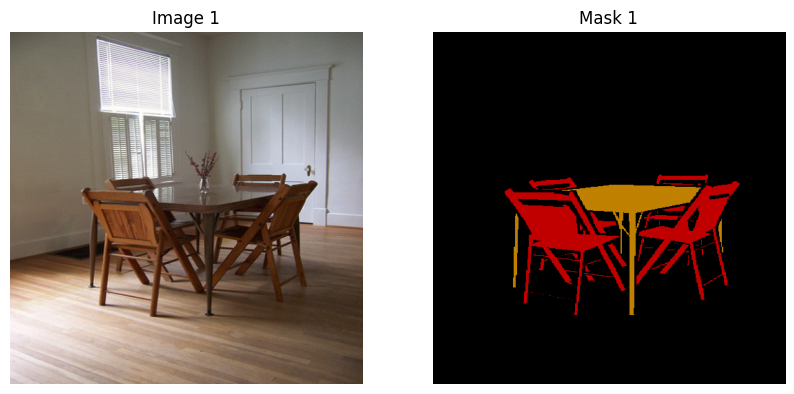

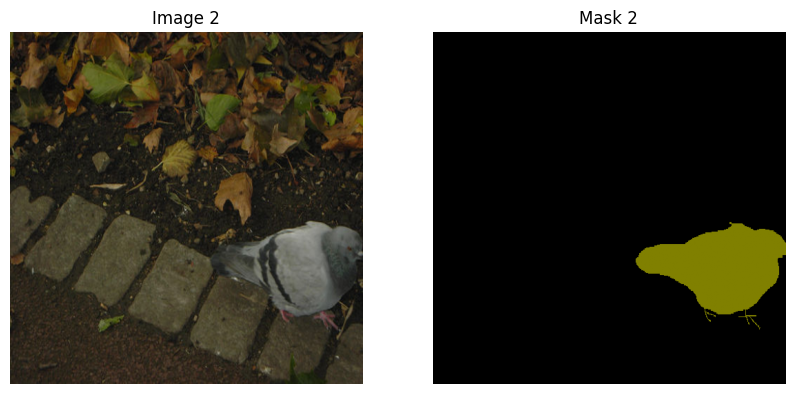

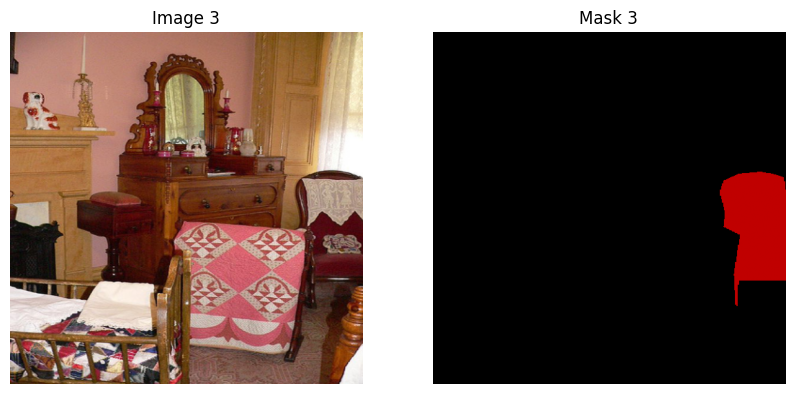

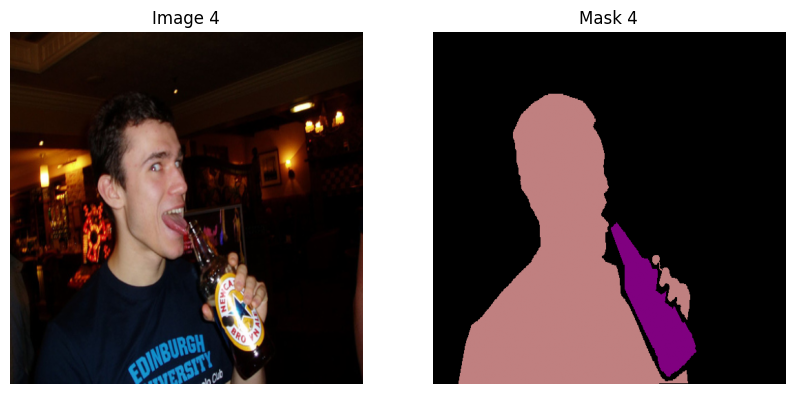

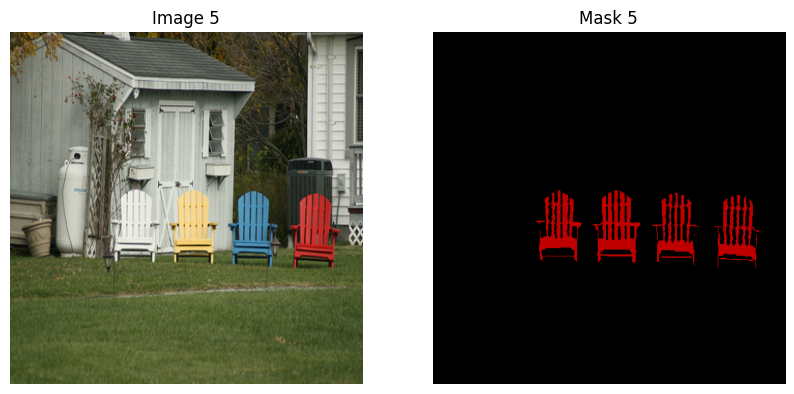

In [30]:
def visualize_image_and_mask_tensors(image_tensors, mask_tensors):
    """
    Visualize lists of image tensors and their corresponding mask tensors as regular images.
    
    Parameters:
        image_tensors (list of torch.Tensor): The list of image tensors to visualize.
        mask_tensors (list of torch.Tensor): The list of mask tensors to visualize.
    """
    for i, (image_tensor, mask_tensor) in enumerate(zip(image_tensors, mask_tensors)):
        # Convert the image tensor to numpy and change to HWC format for visualization
        image_np = image_tensor.permute(1, 2, 0).numpy()

        # Convert the mask tensor to numpy and change to HWC format for visualization
        mask_np = mask_tensor.permute(1, 2, 0).numpy()

        # Display the image and the mask side by side
        plt.figure(figsize=(10, 5))

        # Display the image
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title(f'Image {i+1}')
        plt.axis('off')

        # Display the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np)
        plt.title(f'Mask {i+1}')
        plt.axis('off')

        plt.show()

# For testing, let's use the same image tensors and mask tensors as regular three-channel images
# We'll use the previously defined image_tensors and create new mask_tensors with 3 channels
mask_tensors = [torch.rand(3, 100, 100), torch.rand(3, 100, 100)]

# Test the function
visualize_image_and_mask_tensors(imgs, masks)

In [ ]:
# TODO: Import model here
model = None

In [37]:
from loss_functions import class_balanced_focal_loss
for img, mask in train_loader:
    outs = model(img)
    mask_one_hot = F.one_hot(mask, num_classes=21)
    loss = class_balanced_focal_loss(outs, mask_one_hot, weights = [], gamma=2)
    loss.backward()

torch.Size([64, 512, 512, 21])
torch.Size([64, 512, 512])
